# **Proyecto individual Henry: PI-1-MLOps**
## **Elí Flores**

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Let's do the load of the dataset

*   ```rev```: australian_user_reviews.json
*   ```userItem```: australian_user_items.json
*   ```df```: output_steam_games.json

## Since this notebook was written in Google Colab the paths aim to a file in Google Drive, in local machine the paths will change.

In [ ]:
data = []
with open('/content/drive/MyDrive/PI_1_Henry/australian_user_reviews.json') as fp:
  for line in fp:
    s = eval(line)  #eval() is used to process each line from file .json
    data.append(s)

rev = pd.read_json(json.dumps(data))

In [ ]:
data = []
with open('/content/drive/MyDrive/PI_1_Henry/australian_users_items.json') as fp:
  for line in fp:
    s = eval(line)  #eval() is used to process each line from file .json
    data.append(s)

userItem = pd.read_json(json.dumps(data))

In [ ]:
df = pd.read_json('/content/drive/MyDrive/PI_1_Henry/output_steam_games.json', lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 11.9+ MB


# Let's plot ```df``` (```output_steam_games.json```) to get a visualization of null **values**

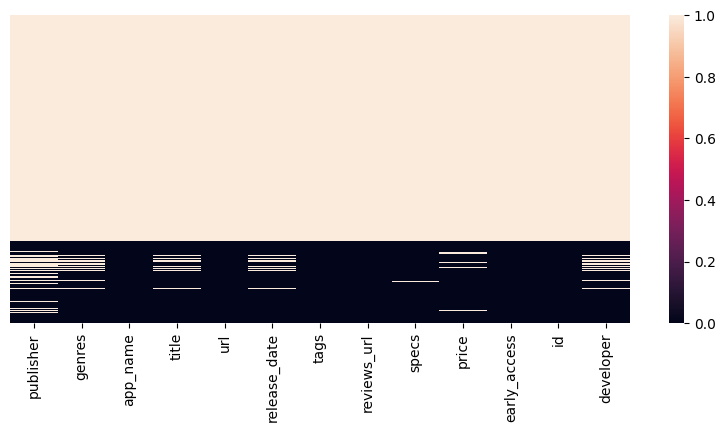

In [ ]:
plt.figure(figsize=(10,4), dpi=100)
sns.heatmap(data=df.isnull(), yticklabels=False)
plt.show()

## -  In the following code let's delete *publisher*, *url*, *reviews_url*, *early_access* and *developer* columns to reduce the size of data and they are considered unnecessary in our study as well.

## -  I delete the null values and reset the index of dataframe

In [ ]:
try:
  df.drop(columns=[
      'publisher',
      'url',
      'reviews_url',
      'early_access',
      'developer'
  ],
        inplace=True)
except Exception as e:
  print(e)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.drop_duplicates(subset=['id'], inplace=True)  #Delete duplicates in id column
df.reset_index(drop=True, inplace=True)          #Reset the index on the dataframe

# I verify if *app_name* = *title* columns, if not we make both values equal

In [ ]:
try:
  df['title'] = df['title'].str.replace('amp;', '')

  df.loc[df['title'] != df['app_name'], 'title'] = df.loc[df['title'] != df['app_name']]['title'].str.replace('®', '')

  df.loc[df['title'] != df['app_name'], 'title'] = df.loc[
      df['title'] != df['app_name']
  ]['title'].str.replace(' Game of the Year Edition', '')

  df.loc[df['title'] != df['app_name'], 'title'] = df.loc[df['title'] != df['app_name']]['title'].str.replace('&gt;', '')

  df.loc[df['title'] != df['app_name'], 'title'] = df.loc[df['title'] != df['app_name']]['title'].str.replace('_', '')

  df.loc[df['title'] != df['app_name'], 'app_name'] = df.loc[df['title'] != df['app_name']]['app_name'].str.replace('_', '')

  df.loc[df['title'] != df['app_name'], 'app_name'] = df.loc[df['title'] != df['app_name']]['app_name'].str.replace('>', '')

  df.loc[(df['title'] != df['app_name']) & (df['app_name'] == '>//:System.Hack'), 'title'] = df.loc[
      (df['title'] != df['app_name']) & (df['app_name'] == '>//:System.Hack'), 'app_name'
  ]

  df.drop(columns=[         # delete app_name column considered unnecessary
      'app_name',           #
],                          #
        inplace=True)       #
except Exception as e:
  print(e)

In [ ]:
df['release_date'] = df['release_date'].str.extract(r'(\d{4})', expand=False)   #Using regex we extract four consecutives numbers (year)
df.dropna(inplace=True)                                                         #Delete nulls, if there are not 4 consecutives number return a null above line
df.reset_index(drop=True, inplace=True)                                         #Reset the index on dataframe

df['id'] = df['id'].apply(int)                                                  #Change the data type to int

df.rename(                                                                      #
    columns = {                                                                 #
        'id': 'id_game',                                                        #
        'release_date': 'year'                                                  #Change the name in soome columns
    },                                                                          #
    inplace = True                                                              #
)                                                                               #

df['year'] = df['year'].apply(int)                                              #Change the data type to int

In [ ]:
df.info()                                                                       #Get the info to know the status of nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27322 entries, 0 to 27321
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   genres   27322 non-null  object
 1   title    27322 non-null  object
 2   year     27322 non-null  int64 
 3   tags     27322 non-null  object
 4   specs    27322 non-null  object
 5   price    27322 non-null  object
 6   id_game  27322 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.5+ MB


# The *genres*, *tags* and *specs* columns are categoricals variables and a single game can share several genres. In order to split in another dataframes, I use ***One Hot Encoding*** to achieve it. The code below apply it


In [ ]:
genres_dummies = pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()
genres_dummies.columns = map(str.lower, genres_dummies.columns)
genres_dummies.rename(
    columns = {
        'animation &amp; modeling': 'animation modeling',
        'design &amp; illustration': 'design illustration'
    },
    inplace = True
)
genres_dummies.drop(columns=[
    'early access',
    'free to play'
],
       inplace=True)
genres_dummies.insert(0, "id_game", df['id_game'])

tags_dummies = pd.get_dummies(df['tags'].explode()).groupby(level=0).sum()
tags_dummies.columns = map(str.lower, tags_dummies.columns)
tags_dummies.insert(0, "id_game", df['id_game'])

specs_dummies = pd.get_dummies(df['specs'].explode()).groupby(level=0).sum()
specs_dummies.columns = map(str.lower, specs_dummies.columns)
specs_dummies.insert(0, "id_game", df['id_game'])

try:                                                                            #
  df.drop(                                                                      #
      columns=[                                                                 #
          'genres',                                                             #
          'tags',                                                               #When we get the dummies
        'specs',                                                                #We can delete de columns
      ],                                                                        #in the dataframe of games
      inplace=True                                                              #
  )                                                                             #
except Exception as e:                                                          #
  print(e)                                                                      #

display(genres_dummies.info())
display(specs_dummies.info())
display(tags_dummies.info())
genres_dummies.to_csv('genres.csv', index=False)
specs_dummies.to_csv('specs.csv', index=False)
tags_dummies.to_csv('tags.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27322 entries, 0 to 27321
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   id_game                27322 non-null  int64
 1   action                 27322 non-null  uint8
 2   adventure              27322 non-null  uint8
 3   animation modeling     27322 non-null  uint8
 4   audio production       27322 non-null  uint8
 5   casual                 27322 non-null  uint8
 6   design illustration    27322 non-null  uint8
 7   education              27322 non-null  uint8
 8   indie                  27322 non-null  uint8
 9   massively multiplayer  27322 non-null  uint8
 10  photo editing          27322 non-null  uint8
 11  rpg                    27322 non-null  uint8
 12  racing                 27322 non-null  uint8
 13  simulation             27322 non-null  uint8
 14  software training      27322 non-null  uint8
 15  sports                 27322 non-nul

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27322 entries, 0 to 27321
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   id_game                     27322 non-null  int64
 1   captions available          27322 non-null  uint8
 2   co-op                       27322 non-null  uint8
 3   commentary available        27322 non-null  uint8
 4   cross-platform multiplayer  27322 non-null  uint8
 5   downloadable content        27322 non-null  uint8
 6   full controller support     27322 non-null  uint8
 7   game demo                   27322 non-null  uint8
 8   in-app purchases            27322 non-null  uint8
 9   includes source sdk         27322 non-null  uint8
 10  includes level editor       27322 non-null  uint8
 11  local co-op                 27322 non-null  uint8
 12  local multi-player          27322 non-null  uint8
 13  mmo                         27322 non-null  uint8
 14  mods  

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27322 entries, 0 to 27321
Columns: 337 entries, id_game to e-sports
dtypes: int64(1), uint8(336)
memory usage: 9.2 MB


None

# In the column *price* some values are string, I want change it to zero, then convert the data type to ```float```

In [ ]:
to_replace = [
    'Free to Play',
    'Free To Play',
    'Free Mod',
    'Play for Free!',
    'Third-party',
    'Install Now',
    'Free HITMAN™ Holiday Pack',
    'Play Now',
    'Play WARMACHINE: Tactics Demo',
    'Play the Demo',
    'Free Demo',
    'Free',
    'Install Theme'
]

df['price'] = df['price'].apply(str)
for item in to_replace:
    if item == 'Free':
        df.loc[df['price']==item, 'price'] = '0'
    else:
        df['price'] = df['price'].str.replace(item, '0', regex=False)
        pass
    pass
df['price'] = df['price'].apply(float)

In [ ]:
df.info()                                                                       #Print the info to show the data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27322 entries, 0 to 27321
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    27322 non-null  object 
 1   year     27322 non-null  int64  
 2   price    27322 non-null  float64
 3   id_game  27322 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 853.9+ KB


# We get the dataframe of ```output_steam_game.json``` abreviated in .csv format and less size

In [ ]:
df.to_csv('games.csv', index=False)
df

,title,year,price,id_game
0,Lost Summoner Kitty,2018,4.99,761140
1,Ironbound,2018,0.00,643980
2,Real Pool 3D - Poolians,2017,0.00,670290
3,弹炸人2222,2017,0.99,767400
4,Battle Royale Trainer,2018,3.99,772540
...,...,...,...,...
27317,Kebab it Up!,2018,1.99,745400
27318,Colony On Mars,2018,1.99,773640
27319,LOGistICAL: South Africa,2018,4.99,733530
27320,Russian Roads,2018,1.99,610660


# This time I work with the ```rev``` (```australian_user_reviews.json```)

In [ ]:
#### user_url is considered unnecesary, then it is deleted ####
try:
  rev.drop(
      columns= [
          'user_url'
      ],
      inplace=True
  )
except Exception as e:
  print(e)
display(rev.info())
display(rev)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  25799 non-null  object
 1   reviews  25799 non-null  object
dtypes: object(2)
memory usage: 403.2+ KB


None

,user_id,reviews
0,76561197970982479,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,"[{'funny': '3 people found this review funny',..."
...,...,...
25794,76561198306599751,"[{'funny': '', 'posted': 'Posted May 31.', 'la..."
25795,Ghoustik,"[{'funny': '', 'posted': 'Posted June 17.', 'l..."
25796,76561198310819422,"[{'funny': '1 person found this review funny',..."
25797,76561198312638244,"[{'funny': '', 'posted': 'Posted July 21.', 'l..."


# This dataframe have nested data, we need to unnest the data in the *reviews* column. Below we do that.

In [ ]:
rev_1 = rev.explode(column=['reviews'])                                         #.explode() expand the item inside the list in reviews to a new row
rev_1.dropna(inplace=True)                                                      #delete nulls
rev_1.reset_index(drop=True, inplace=True)                                      #and reset the index in the dataframe rev_1

#### Now each row in reviews is a dictionarie, then we need ####
#### extract each key-value, so that we can get new column- ####
#### value to generate new columns                          ####

list_ = map(lambda x: eval(str(x)), rev_1['reviews'].values.tolist())           #the values in reviews are inserted in a list
                                                                                #each items in list are converted in str
list_ = list(list_)                                                             #list_ is converted to list data type
only_reviews_nested = pd.read_json(json.dumps(list_))                           #We create a dataframe

review_cleaned_unnested = pd.concat(                                            #Let's concatenate rev_1
    [rev_1, only_reviews_nested],                                               #and the unnested data
    axis=1                                                                      #process above
)                                                                               #

review_cleaned_unnested.rename(                                                 #
    columns = {                                                                 #
        'item_id': 'id_game',                                                   #Rename de column item_id to id_game, so that
    },                                                                          #we can relate reviews data with games data
    inplace = True                                                              #
)                                                                               #

#### Delete unnecessary columns ####
try:
  review_cleaned_unnested.drop(
      columns= [
          'reviews',
          'funny',
          'helpful',
          'last_edited'
      ],
      inplace=True
  )
except Exception as e:
  print(e)
#####################################

#### Rename posted column to year ####
review_cleaned_unnested.rename(
    columns = {
        'posted': 'year'
    },
    inplace = True
)
#######################################

#### In the following lines we do:                       ####
#### - Extract 4 consecutive numbers (year)              ####
#### - Delete nulls values and reset index               ####
#### - Convert year and recommend columns to int         ####
#### - Only extract rows with not empty value            ####
#### - Delete null and duplicated values and reset index ####

review_cleaned_unnested['year'] = review_cleaned_unnested['year'].str.extract(r'(\d{4})', expand=False)
review_cleaned_unnested.dropna(inplace=True)
review_cleaned_unnested.reset_index(drop=True, inplace=True)
review_cleaned_unnested['year'] = review_cleaned_unnested['year'].apply(int)
review_cleaned_unnested['recommend'] = review_cleaned_unnested['recommend'].apply(int)
review_cleaned_unnested = review_cleaned_unnested[review_cleaned_unnested['review'] != ''].copy()
review_cleaned_unnested.dropna(subset=['year'], inplace=True)
review_cleaned_unnested.drop_duplicates(inplace=True)
review_cleaned_unnested.reset_index(drop=True, inplace=True)

In [ ]:
display(review_cleaned_unnested)
display(review_cleaned_unnested.info())
display(review_cleaned_unnested[(review_cleaned_unnested['user_id']=='76561197970982479') & (review_cleaned_unnested['id_game']==43110)])
review_cleaned_unnested.to_csv('reviews.csv', index=False)

,user_id,year,id_game,recommend,review
0,76561197970982479,2011,1250,1,Simple yet with great replayability. In my opi...
1,76561197970982479,2011,22200,1,It's unique and worth a playthrough.
2,76561197970982479,2011,43110,1,Great atmosphere. The gunplay can be a bit chu...
3,js41637,2014,251610,1,I know what you think when you see this title ...
4,js41637,2013,227300,1,For a simple (it's actually not all that simpl...
...,...,...,...,...,...
48466,wayfeng,2015,730,1,its FUNNNNNNNN
48467,76561198251004808,2015,253980,1,Awesome fantasy game if you don't mind the gra...
48468,72947282842,2015,730,1,Prettyy Mad Game
48469,ApxLGhost,2015,730,1,AMAZING GAME 10/10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48471 entries, 0 to 48470
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    48471 non-null  object
 1   year       48471 non-null  int64 
 2   id_game    48471 non-null  int64 
 3   recommend  48471 non-null  int64 
 4   review     48471 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.8+ MB


None

,user_id,year,id_game,recommend,review
2,76561197970982479,2011,43110,1,Great atmosphere. The gunplay can be a bit chu...


# Finally, let's do the transformations in ```userItem``` (```australian_user_item.json```). In order to make useful this dataset, we delete unnecessary columns, expand nested values, convert data types and so on.

In [ ]:
userItem_1 = userItem.drop(columns=['user_url', 'items_count', 'steam_id']).copy()            #delete unnecessary columns
userItem_1 = userItem_1.explode(column='items').dropna(subset=['items'])                      #expand nested values and delete nulls values
userItem_1.reset_index(drop=True, inplace=True)                                               #reset index

#### Each line in items is a dictionarie, let's create two columns ####
#### 1) id_game, using .apply() the value of key item_id in items  ####
#### wil be the values of the column id_game.                      ####
#### 2) the same way we set playtime_forever                       ####
userItem_1['id_game'] = userItem_1['items'].apply(lambda x:x['item_id'])
userItem_1['playtime_forever'] = userItem_1['items'].apply(lambda x:x['playtime_forever'])
#######################################################################

userItem_1.drop(columns=['items'], inplace=True)                                              #delete the unnecessary column items
userItem_1['id_game'] = userItem_1['id_game'].apply(int)                                      #convert id_gam column to int
userItem_1['user_id'] = userItem_1['user_id'].apply(str)                                      #convert id_gam column to str
userItem_1['playtime_forever'] = userItem_1['playtime_forever'].apply(lambda x: int(x)/60)    #the unit of playtime_forever is minutes, convert to hours
userItem_1.drop_duplicates(inplace=True)                                                      #delete duplicates
userItem_1 = userItem_1[userItem_1['playtime_forever']<8760].reset_index(drop=True)           #filter playtime_time less than 8760 hours andreset index

display(userItem_1)                                                                           #print userItem_1 dataframe

,user_id,id_game,playtime_forever
0,76561197970982479,10,0.100000
1,76561197970982479,20,0.000000
2,76561197970982479,30,0.116667
3,76561197970982479,40,0.000000
4,76561197970982479,50,0.000000
...,...,...,...
5094080,76561198329548331,346330,0.000000
5094081,76561198329548331,373330,0.000000
5094082,76561198329548331,388490,0.050000
5094083,76561198329548331,521570,0.066667


# In order to get a more light .csv file to the API, specifically the function ```PlayTimeGenre( genre: str )```, we group by ```id_game``` adding up ```playtime_forever```.

In [ ]:
playTimePerGame = userItem_1.groupby(                       #
    by='id_game', as_index=False                            #we group by id_game, then we apply aggregation function
).agg(                                                      #to playtime_forever. the column user_id is deleted because
    playtime_forever=('playtime_forever', 'sum')            #it's not necessary this time
)                                                           #

playTimePerGame.to_csv('playtimePerGame.csv', index=False)  #get .csv file

#### The lines below show the query to get the serie with release year ####
#### and playtime_forever, in this case genre=indie                    ####
playTimePerGame = playTimePerGame.merge(df[['id_game', 'year']], on='id_game')  #Merge with clean output_steam_games.json
playTimePerGame = playTimePerGame.merge(genres_dummies, on='id_game')           #Merge with genres_dummies necessary to filter by genre
playTimePerGame.drop(columns=['id_game'], inplace=True)                         #id_game column is not necessary, so delete it
playTimePerGame[playTimePerGame['indie']==1].groupby(by='year').agg(playtime_forever=('playtime_forever', 'sum')).sort_values(by='playtime_forever', ascending=False)

,playtime_forever
year,
2006,7.405123e+06
2011,3.727397e+06
2013,2.955391e+06
2015,2.883571e+06
2017,2.093236e+06
2012,2.052770e+06
2014,1.531647e+06
2016,1.491743e+06
2010,1.417865e+05


# In order to get a more light .csv file to the API, specifically the function ```PlayTimeGenre( genre: str )```, we group by ```id_game``` adding up ```playtime_forever```.

In [ ]:
playtimePerUser = userItem_1.merge(                                             # Merge userItem_1 with review_cleaned_unnested
    review_cleaned_unnested[['user_id', 'id_game', 'year']],                    #
    on=['user_id', 'id_game']                                                   # The merge is on user_id and id_game
)
playtimePerUser = playtimePerUser.merge(genres_dummies, on='id_game')           # Merge with genres_dummiesto filter by genre in the future
playtimePerUser['year'] = playtimePerUser['year'].apply(int)                    # Convert year to int
print("playtime_forever of the user thiefofrosesinlalaland \n")
display(playtimePerUser[playtimePerUser['user_id']=='thiefofrosesinlalaland'])  # show a query to one user
print('\n')
playtimePerUser = playtimePerUser.drop(columns=['id_game'])                     # id_game column isn't necessary, let's delete it
playtimePerUser.to_csv('playTimePerUser.csv', index=False)                      # Generate a .csv file to use in API

#### Let's do a query to show a demostration ####
print("Users with the most playtime for genre=indie")
playtimePerUser[playtimePerUser['indie']==1].groupby(by='user_id', as_index=False).agg(playtime_forever=('playtime_forever', 'sum')).sort_values(by='playtime_forever', ascending=False)

playtime_forever of the user thiefofrosesinlalaland 



,user_id,id_game,playtime_forever,year,action,adventure,animation modeling,audio production,casual,design illustration,...,photo editing,rpg,racing,simulation,software training,sports,strategy,utilities,video production,web publishing
14424,thiefofrosesinlalaland,287700,331.116667,2015,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19346,thiefofrosesinlalaland,22380,558.983333,2014,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
20125,thiefofrosesinlalaland,99900,6159.950000,2014,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
26401,thiefofrosesinlalaland,209650,26.916667,2014,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26694,thiefofrosesinlalaland,289650,285.300000,2014,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27827,thiefofrosesinlalaland,268050,76.433333,2014,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0




Users with the most playtime for genre=indie


,user_id,playtime_forever
6563,ThisIsWhereIGetOff,8344.950000
5786,Nuclueus,8213.500000
9141,saltymotherfucker,6550.283333
5038,H-O-B-O,6297.300000
9556,thiefofrosesinlalaland,6159.950000
...,...,...
8797,oopashfdiohasld,0.083333
5406,LSF4123,0.083333
7918,helenangel,0.066667
2521,76561198073280815,0.066667


# Sentiment analysis
## After to do the transformation we've got four functional .csv files

*   games.csv
*   reviews.csv
*   playtimePerGame.csv for the function ```PlayTimeGenre(genre)```
*   playTimePerUser.csv forthe function ```UserForGenre(genre)```

## Then, we need the sentiment analysis to get the functions:

*   ```UserRecommend( year: int )```
*   ```UserNotRecommend( year: int )```
*   ```sentiment_analysis( year: int )```

## This analysis have a workflow

1.   Preprocessing text
2.   Compute polarity_scores.

## Both steps use the NLTK library to NLP


In [ ]:
#### Import the necessary libraries ####

import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# download nltk corpus (first time only)
import nltk
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.corpus import words
!pip install contractions
import contractions

nltk.download('all')
pd.set_option('display.max_rows', 1000)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.4 MB/s eta 0:00:00


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
#### Let's define a function to tag each token ####
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
#### Let's define a function to hand negative sentence                  ####
#### source: https://github.com/UtkarshRedd/Negation_handling/tree/main ####

def negation_handler(sentence):
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

In [ ]:
# create preprocess_text function
from collections import Counter
def preprocess_text(text):

  expanded_words = []
  for word in text.split():
    # using contractions.fix to expand the shortened words
    #example: I'll = I will
    expanded_words.append(contractions.fix(word))

  text = " ".join(expanded_words)                                               #join the items in expanded_words into a string
  text=re.sub("[^a-zA-Z]", " ", str(text))                                      #filter only letters

  # Tokenize the text

  tokens = word_tokenize(text.lower())
  tokens = negation_handler(tokens)                                             #apply the function defines above negation handler

  tokens = [word for word in tokens if len(word)>2]                             #delete words with two letters or less

  # Remove stop words

  filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

  # Lemmatize the tokens

  lemmatizer = WordNetLemmatizer()

  lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in filtered_tokens]

  lemmatized_tokens= [
      item[0] for item in sorted(
          Counter(lemmatized_tokens).most_common(10), key=lambda w: w[1], reverse=True
      )
  ]
  # Join the tokens back into a string

  processed_text = ' '.join(lemmatized_tokens)

  return processed_text

# apply the function df
review_cleaned_unnested['preProcessRev'] = review_cleaned_unnested['review'].apply(preprocess_text)

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)       #get the polarity_scores

    if scores['compound'] < 0:
      sentiment = 0
    elif scores['compound'] == 0:
      sentiment = 1
    else:
      sentiment = 2
    return sentiment

# apply get_sentiment function

review_cleaned_unnested['sentiment'] = review_cleaned_unnested['preProcessRev'].apply(get_sentiment)

# Let's save in a new variable the result
*   Delete the columns ```review``` and ```preProcessRev```
*   Delete rows with nulls values
*   Reset index


In [ ]:
ultimate_revSentimentAnalysis = review_cleaned_unnested.where(review_cleaned_unnested['preProcessRev']!='')
ultimate_revSentimentAnalysis.drop(columns=['review', 'preProcessRev'], inplace=True)
ultimate_revSentimentAnalysis.dropna(subset=['year'], inplace=True)
ultimate_revSentimentAnalysis.reset_index(drop=True, inplace=True)
ultimate_revSentimentAnalysis

,user_id,year,id_game,recommend,sentiment
0,76561197970982479,2011.0,1250.0,1.0,2.0
1,76561197970982479,2011.0,22200.0,1.0,2.0
2,76561197970982479,2011.0,43110.0,1.0,2.0
3,js41637,2014.0,251610.0,1.0,2.0
4,js41637,2013.0,227300.0,1.0,2.0
...,...,...,...,...,...
46751,wayfeng,2015.0,730.0,1.0,1.0
46752,76561198251004808,2015.0,253980.0,1.0,2.0
46753,72947282842,2015.0,730.0,1.0,0.0
46754,ApxLGhost,2015.0,730.0,1.0,2.0


# Generate the .csv file of the sentiment_analysis

In [ ]:
ultimate_revSentimentAnalysis.to_csv('sentiment_analysis.csv', index=False)